# Amazon Ürün Yorumları ile Duygu Analizi (Gözetimli Öğrenme)

Bu projede, Amazon'dan alınan kullanıcı yorumları kullanılarak bir yorumun **olumlu mu yoksa olumsuz mu** olduğunu tahmin eden bir makine öğrenmesi modeli geliştirilmektedir.


In [38]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline

## Veri Setinin Yüklenmesi

Veri seti, ürün yorumlarını ve puanlarını içermektedir. `Reviews.csv` dosyasını Pandas ile yüklüyoruz.


In [39]:
df =pd.read_csv("Reviews.csv")

## Veri Seti Özeti

Bu adımda veri setinin yapısı incelenmiştir. `df.info()` fonksiyonu ile:

- Kaç satır ve sütun olduğu
- Her sütunun veri tipi (object, int, float vb.)
- Eksik veri (null) olup olmadığı

görülmüştür. Bu temel inceleme, veri temizliği adımlarını planlamadan önce atılması gereken ilk adımdır.


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [41]:
df.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


## Keşifsel Veri Analizi (EDA) ve Veri Görselleştirmeleri

Bu bölümde, veri setinin yapısını, dağılımlarını ve olası anormallikleri anlamak için keşifsel veri analizi (EDA) adımları uygulanmıştır. Görselleştirmeler aracılığıyla veri setindeki puan ve duygu dağılımları, yorum uzunlukları incelenmiştir.

### Puan Dağılımı

Amazon yorumlarındaki 1'den 5'e kadar olan puanların dağılımını gösteren bir grafik oluşturulmuştur. Bu, kullanıcıların ürünleri genel olarak nasıl değerlendirdiğine dair bir fikir verir ve veri setinin genel eğilimini ortaya koyar.

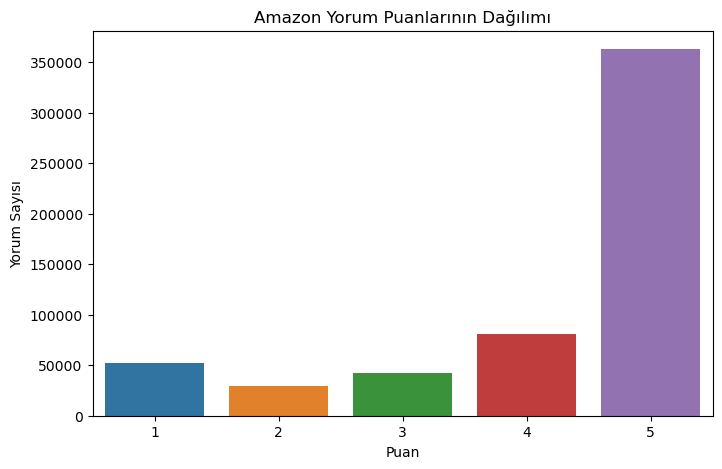

In [42]:
# puan (Score) değişkeninin dağılımını gösteren çubuk grafik
plt.figure(figsize=(8, 5))
sns.countplot(x='Score', data=df)
plt.title('Amazon Yorum Puanlarının Dağılımı')
plt.xlabel('Puan')
plt.ylabel('Yorum Sayısı')
plt.show()

### Duygu Dağılımı

`Score` sütunundan türetilen ikili `Sentiment` (Duygu) sütununun (1: Pozitif, 0: Negatif) dağılımı görselleştirilmiştir. Bu grafik, veri setindeki sınıf dengesizliğini anlamak açısından kritik öneme sahiptir. Görüldüğü üzere, pozitif yorumlar (1) veri setinde büyük çoğunluğu oluşturmaktadır. Bu durum, model eğitiminde `class_weight='balanced'` gibi yöntemlerin neden önemli olduğunu açıklar.

**Not:** Bu grafik, `Score` 3 olan yorumlar çıkarılmadan önceki genel duygu dağılımını gösterir. `df_filtered` oluşturulduktan sonra daha kesin bir duygu dağılımı elde edilebilir.

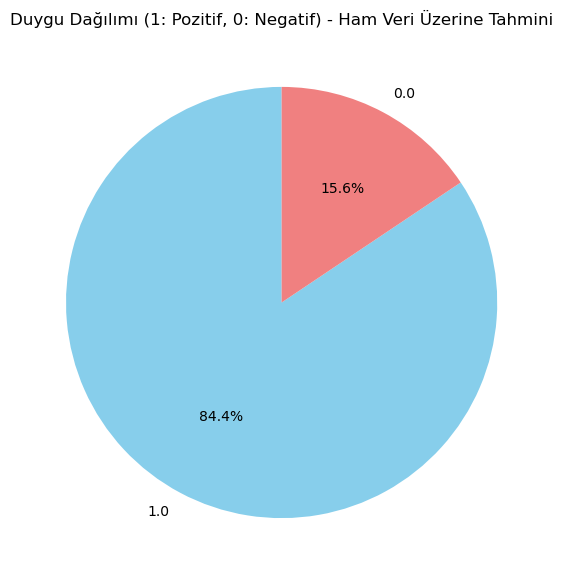

In [43]:
# duygu (Sentiment) dağılımını gösteren pasta grafik
temp_sentiment = df['Score'].apply(lambda x: 1 if x > 3 else (0 if x < 3 else None)).dropna()
plt.figure(figsize=(7, 7))
temp_sentiment.value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
plt.title('Duygu Dağılımı (1: Pozitif, 0: Negatif) - Ham Veri Üzerine Tahmini')
plt.ylabel('')
plt.show()

 `df_filtered` henüz oluşturulmadığı için df üzerinde Score'a göre geçici bir Sentiment sütunu oluşturup kullanabiliriz veya bu grafiği df_filtered oluşturulduktan sonraki bir hücreye taşıyabiliriz.
 Mevcut akışta, `df_filtered` oluşturulduktan sonra daha doğru olacaktır. Şimdilik `df` üzerinde geçici olarak gösterelim, ancak df_filtered sonrası güncellenebilir.

## Etiketleme (Labeling)

Yorumların puanlarına göre duygu etiketi oluşturuyoruz:
- 1–2 puan → Olumsuz (0)
- 4–5 puan → Olumlu (1)
- 3 puan → Nötr, bu veriler analiz dışı bırakılır.

In [44]:
df=df[df['Score']!=3] #3 puanlı verileri karışıklık yaratmaması için sildim
df['Sentiment'] = df['Score'].apply(lambda x: 1 if x > 3 else 0) #olumlu=1, olumsuz=0
df['Sentiment'].value_counts() #kaç tane olumsuz var?

Sentiment
1    443777
0     82037
Name: count, dtype: int64

## Gerekli Sütunların Seçilmesi

Veri seti birçok farklı sütun içermektedir (örneğin: ürün adı, kullanıcı adı, tarih vb.). Ancak bu proje kapsamında yalnızca yorum metni (`Text`) ve etiket (`Sentiment`) kullanılacaktır.

Bu nedenle yalnızca bu iki sütun seçilerek veri seti sadeleştirilmiştir:

- `Text`: Kullanıcının yazdığı ürün yorumu
- `Sentiment`: Bu yorumun olumlu (1) ya da olumsuz (0) olduğu etiketi


In [45]:
df = df[['Text', 'Sentiment']]
df.head()

,Text,Sentiment
0,I have bought several of the Vitality canned d...,1
1,Product arrived labeled as Jumbo Salted Peanut...,0
2,This is a confection that has been around a fe...,1
3,If you are looking for the secret ingredient i...,0
4,Great taffy at a great price. There was a wid...,1


## Metin Temizleme

Yorumların daha sağlıklı analiz edilebilmesi için:
- Küçük harfe çevirme
- Noktalama işaretlerinin kaldırılması
- Fazla boşlukların temizlenmesi  
gibi işlemler uygulanmaktadır.

In [46]:
def temizle(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['Clean_Text'] = df['Text'].apply(temizle)
df[['Clean_Text', 'Sentiment']].head(10)

,Clean_Text,Sentiment
0,i have bought several of the vitality canned d...,1
1,product arrived labeled as jumbo salted peanut...,0
2,this is a confection that has been around a fe...,1
3,if you are looking for the secret ingredient i...,0
4,great taffy at a great price there was a wide ...,1
5,i got a wild hair for taffy and ordered this f...,1
6,this saltwater taffy had great flavors and was...,1
7,this taffy is so good it is very soft and chew...,1
8,right now im mostly just sprouting this so my ...,1
9,this is a very healthy dog food good for their...,1


## Özellik Çıkarımı (TF-IDF)

TF-IDF (Term Frequency - Inverse Document Frequency) yöntemiyle, her yorumdaki kelimelerden sayısal vektörler oluşturulmaktadır. Bu vektörler, yorumların içeriksel benzerliğini sayısal olarak karşılaştırabilmek için gereklidir.


In [47]:
tfidf = TfidfVectorizer(max_features=5000)
x = tfidf.fit_transform(df['Clean_Text']) #yorumların sayısal hali
y = df['Sentiment'].values #etiket

# **Model Optimizasyonu ve Güvenilirliği**
Bu bölümde, Logistic Regression modelinin performansını daha güvenilir bir şekilde değerlendirmek ve hiperparametrelerini optimize etmek için gelişmiş teknikler kullanılmıştır.
## Modelin Eğitilmesi (Logistic Regression)

Veri eğitim ve test olarak ikiye ayrılır. Ardından Logistic Regression modeli eğitilerek, yorumların etiketleri tahmin edilir.


In [48]:
#veriyi bölme
#%80 eğitim, %20 test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [49]:
model = LogisticRegression(max_iter=1000)
model.fit(x_train, y_train)

LogisticRegression(max_iter=1000)

## Modelin Değerlendirilmesi

Modelin doğruluğu, **precision, recall** ve **F1-score** gibi metriklerle ölçülür.


In [50]:
y_pred = model.predict(x_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[11542  4837]
 [ 2058 86726]]
              precision    recall  f1-score   support

           0       0.85      0.70      0.77     16379
           1       0.95      0.98      0.96     88784

    accuracy                           0.93    105163
   macro avg       0.90      0.84      0.87    105163
weighted avg       0.93      0.93      0.93    105163



Bu model genel olarak yüksek doğruluk verdi:  
- **Accuracy %93** ile oldukça güçlü bir performans sağlandı.
- Olumlu yorumlar (sınıf 1) model tarafından çok iyi tanındı (**Recall %98**).
- Ancak olumsuz yorumlar (sınıf 0) için model biraz zayıf kaldı (**Recall %70**).  
  Yani model, “negatif yorumu olumlu sanma” eğiliminde olabilir.

Bu sonuç, veri dengesizliğinin etkisini açıkça gösteriyor. Yine de genel başarı oldukça yüksek.


## Sonuç ve Yorum

Bu analizde, Amazon yorumları üzerinde gözetimsiz bir yöntem olan KMeans kullanılarak kümelendirme yapılmıştır. Bu yaklaşım özellikle etiketlenmemiş büyük veri setlerinde faydalıdır.  
Gelecekte, bu kümeler üzerinden manuel etiketleme yapılabilir veya öneri sistemleri için kullanılabilir.


## ✨BONUS✨
## Dengesiz Veri için Alternatif Model

Modelimizi eğitirken dikkat çeken bir nokta vardı:  
Yorumların büyük çoğunluğu **olumlu**. Bu da, modelin olumlu sınıfı çok iyi öğrenip, **olumsuz yorumları göz ardı etmesine** neden olabilir.

Bu durumu iyileştirmek için, `LogisticRegression` modeline `class_weight='balanced'` parametresini verdik.  
Bu ayar sayesinde, model azınlık sınıf olan **negatif yorumlara daha fazla önem** veriyor.

Amaç şu:  
- "Olumlu-olumsuz oranı dengesizse, her iki sınıfı da eşit öğrenmeye çalış."

Bu yöntemle modelin genel doğruluğu biraz düşebilir ama **adaletli tahmin** artar — özellikle olumsuz yorumlar daha doğru tanınabilir.

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

'''Alternatif Model:
   Azınlık sınıfa verilen önemi artırmak için'''
model_balanced = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

# train
model_balanced.fit(x_train, y_train)

# tahmin
y_pred_balanced = model_balanced.predict(x_test)

# Değerlendirme
print(confusion_matrix(y_test, y_pred_balanced))
print(classification_report(y_test, y_pred_balanced))


[[14855  1524]
 [ 8502 80282]]
              precision    recall  f1-score   support

           0       0.64      0.91      0.75     16379
           1       0.98      0.90      0.94     88784

    accuracy                           0.90    105163
   macro avg       0.81      0.91      0.84    105163
weighted avg       0.93      0.90      0.91    105163



Alternatif modelden gelen sonuçlar oldukça dikkat çekici:

- **Olumsuz yorumlar** (sınıf 0) artık çok daha iyi tanınıyor:  
  Recall %70’ten **%91’e** çıktı 
- Precision (isabet oranı) biraz azalsa da, bu değişim daha adaletli bir tahmin modeli elde etmemizi sağladı.
- **Genel doğruluk** %93'ten %90'a düştü ama bu kontrollü ve kabul edilebilir bir değişim.

Bu model, özellikle olumsuz yorumlara duyarlı olmak isteyen sistemler (örneğin: `müşteri şikayet analizi`) için daha kullanışlı olabilir.
